# Outcome model with no stroke team

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier

## Get data and fit model

In [2]:
# Fields for model
X_fields = [
    'prior_disability',
    'stroke_severity',
    'stroke_team',
    'onset_to_thrombolysis',
    'age',
    'precise_onset_known',
    'any_afib_diagnosis'
    ]
# Load data and get X and y
data = pd.read_csv('./data/data_for_ml/complete_ml_data.csv', low_memory=False)
# Limit to infarction = 1
mask = data['infarction'] == 1
data = data[mask]
# Reindex
data = data.reset_index(drop=True)
stroke_teams = list(data['stroke_team'].unique())
stroke_teams.sort()
# Restrict to fields to use
fields_to_use = X_fields + ['discharge_disability']
data = data[fields_to_use]
# One hot encode stroke teams using OneHotEncoder with stroke_teams as categories
enc = OneHotEncoder(categories=[stroke_teams])
enc.fit(data[['stroke_team']])
one_hot = enc.transform(data[['stroke_team']]).toarray()
one_hot = pd.DataFrame(one_hot, columns=stroke_teams)
data = pd.concat([data, one_hot], axis=1)
data = data.drop(columns=['stroke_team'])
# Get X and y
X = data.drop(columns=['discharge_disability'])
y = data['discharge_disability']
# Fit model and save
model = XGBClassifier(random_state=42)
model.fit(X, y);

## Get prediction for a patient

In [11]:
patient = {
    'prior_disability': 0,
    'stroke_severity': 2,
    'stroke_team': 'Torbay Hospital',
    'onset_to_thrombolysis': 120,
    'age': 75,
    'precise_onset_known': 0,
    'any_afib_diagnosis': 1
}

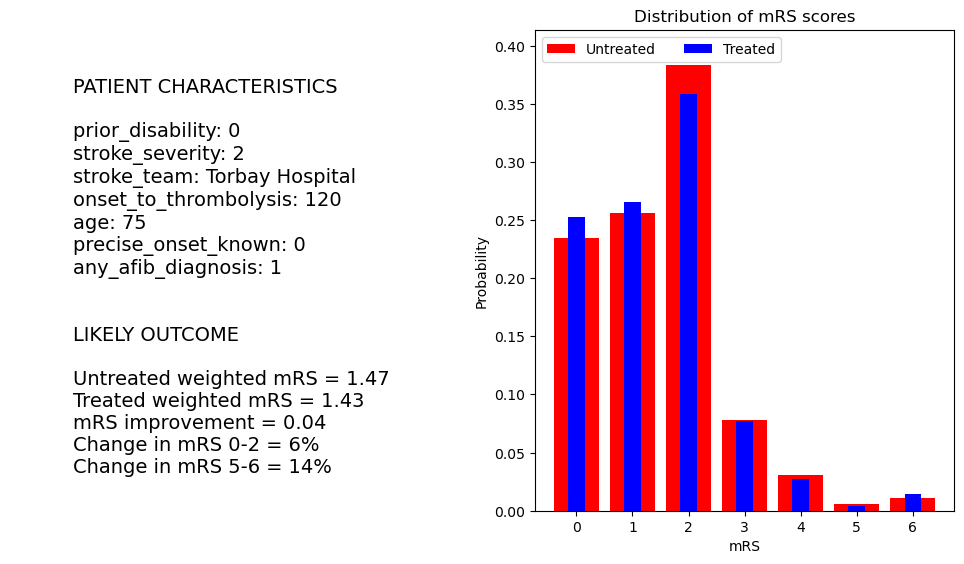

In [12]:
# PLOT

# Convert patient to dataframe
patient = pd.DataFrame(patient, index=[0])

# One hot encode stroke team with encoder fitted on X
one_hot_encoded = enc.transform(patient[['stroke_team']]).toarray()
one_hot_encoded_df = pd.DataFrame(one_hot_encoded, columns=stroke_teams, index=[0])
patient_treated = pd.concat([patient, one_hot_encoded_df], axis=1)
patient_treated.drop('stroke_team', axis=1, inplace=True)

# Get prediction for treated patient
treated = model.predict_proba(pd.DataFrame(patient_treated, index=[0]))[0]

# Switch patient to untreated and get prediction
patient_untreated = patient_treated.copy()
patient_untreated['onset_to_thrombolysis'] = -10
untreated = model.predict_proba(pd.DataFrame(patient_untreated, index=[0]))[0]

# Get weighted average of mRS scores
weighted_untreated = np.sum(untreated * np.arange(7))
weighted_treated = np.sum(treated * np.arange(7))
diff = weighted_treated - weighted_untreated

# Get probabilities of mRS <3
untreated_less_3 = np.sum(untreated[:2])
treated_less_3 = np.sum(treated[:2])
diff_less_3 = ((treated_less_3 / untreated_less_3) * 100) - 100

# Get probabilities of mRS >4
untreated_more_4 = np.sum(untreated[5:])
treated_more_4 = np.sum(treated[5:])
diff_more_4 = ((treated_more_4 / untreated_more_4) * 100) -100

# Draw a dotted histogram of the untreated and treated distributions
fig = plt.figure(figsize=(10, 6))

# Add patient dictionary as a text box
ax = fig.add_subplot(121)
patient_dict = patient.iloc[0].to_dict()
patient_text = 'PATIENT CHARACTERISTICS\n\n'

patient_text = patient_text + (
    '\n'.join([f'{k}: {v}' for k, v in patient_dict.items()]))

patient_text = patient_text + '\n\n\nLIKELY OUTCOME\n'

patient_text = patient_text + f'\nUntreated weighted mRS = {weighted_untreated:0.2f}'
patient_text = patient_text + f'\nTreated weighted mRS = {weighted_treated:0.2f}'
patient_text = patient_text + f'\nmRS improvement = {-diff:.2f}'
patient_text = patient_text + f'\nChange in mRS 0-2 = {diff_less_3:.0f}%'
patient_text = patient_text + f'\nChange in mRS 5-6 = {diff_more_4:.0f}%'

ax.text(0.15, 0.90, patient_text, transform=ax.transAxes, fontsize=14,
        verticalalignment='top')

# Remove all axes
ax.axis('off')

# Plot outcomes
ax = fig.add_subplot(122)
x = np.arange(7)
ax.bar(x, untreated, color='red', label=f'Untreated', 
       linewidth=1, linestyle='--')
ax.bar(x, treated, color='blue', label=f'Treated',
       linewidth=1, linestyle='--', width=0.3)
ax.legend(ncols=2, loc='upper left')
ax.set_xlabel('mRS')
ax.set_ylabel('Probability')
ax.set_title(f'Distribution of mRS scores')

# Set ylim to be 0.03 more than the maximum probability
ax.set_ylim(0, np.max([np.max(untreated), np.max(treated)]) + 0.03)

plt.tight_layout(pad=2)
plt.show()